In [4]:
import pandas as pd
import numpy as np
import rdata
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [16,9]

# models
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

# tools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import partial_dependence, GradientBoostingRegressor, GradientBoostingClassifier

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, \
                            precision_score, confusion_matrix, f1_score, roc_curve

import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')


from scipy.stats import randint as sp_randint

# Support vector machines

Idea działania modelu 'Maszyny wektorów wspierających' (SVM) jest rozszerzeniem idei działania regresji logistycznej - wektor wejściowy modelu jest wektorem wyjściowym funkcji charakteryzującej jądro modelu.
Dostępne jądra maszyny wektorów wspierających:
* radial basis function - określenie podobieństwa do punktów ze zbioru uczącego: C - szerokość granicy, gamma - stopień przeuczenia
* linear - znalezienie płaszczyzny dzielącej zbiory - parametry: C - szerokość granicy
* polynomial - znalezienie powierzchni wielomianowej dzielącej zbiory: C - szerokość granicy, degree - maksymalny stopień zmiennej, gamma - stopień przeuczenia

Praca udostępniona w linku wyraźnie wskazuje w 8. rozdziale na potrzebę normalizacji danych, dla poprawnego działania modelu.

## Wybrany zbiór

Zbiory, którymi będę się zajmował, to *apartments* z pakietu DaLeX i *breast_cancer* z pakietu sklearn.datasets. Pierwszy zajmuje się problemem regresyjnym - przewidywania ceny mieszkania za metr kwadratowy w Warszawie.

# Apartments

## stworzenie modelu SVM  z losowymi parametrami, normalizacją i target encodingiem na kolumnie 'district'

In [5]:
df = rdata.conversion.convert(rdata.parser.parse_file("apartments.rda"))['apartments']
df_test = rdata.conversion.convert(rdata.parser.parse_file("apartments_test.rda"))['apartments_test']
X, y = df.drop('m2.price', axis=1), df.loc[:,'m2.price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

steps = [('TargetEncoder', ce.TargetEncoder(cols=['district'], handle_unknown='ignore')),
        ('StandardScaler', StandardScaler()),
        ('SVR', SVR())]

transform_pipeline = Pipeline(steps[:-1])

transform_pipeline.fit(X_train,y_train)

transformed_X_train = transform_pipeline.transform(X_train)
param_distributions = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                            'C': sp_randint(1,10000),
                             'gamma': sp_randint(1,100),
                             'degree': sp_randint(2,5)}

model = SVR(kernel='rbf', C=1300, gamma=.8)
model.fit(transformed_X_train, y_train)

# rscv = RandomizedSearchCV(SVR(), param_distributions, cv=3, n_jobs=3, n_iter = 1, verbose=True)
# rscv.fit(raw_X_train, y_train)

SVR(C=1300, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.8,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [6]:
print(f'the best estimator mse is: {mean_squared_error(y_test, model.predict(transform_pipeline.transform(X_test)))}')
print(f'the best estimator mae is {mean_absolute_error(y_test, model.predict(transform_pipeline.transform(X_test)))}')
print(f'The best r2 score is: {r2_score(y_test, model.predict(transform_pipeline.transform(X_test)))}')

the best estimator mse is: 37059.57771697624
the best estimator mae is 129.51749128126227
The best r2 score is: 0.9587191624321497


# Breast cancer dataset

Breast cancer dataset zawiera w sobie wiele zmiennych numerycznych - są one do tego stopnia różnicujące, że nawet regresja logistyczna osiąga skuteczności rzędu 98%. W celu zmierzenia różnicy między svm a regresją logistyczną wybieram losowy podzbiór zmiennych, żeby zwiększyć bias modelu.

In [7]:
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    return df

def evaluate_classifiers(X_test, y_test, classifiers):
    """
        Evaluates given classifiers
        returns: pandas.DataFrame containing calculated model' quality metrics
    """
    scores_df = pd.DataFrame()
    for classifier_name, classifier in classifiers.items():
        y_pred = classifier.predict(X_test)
        y_pred_proba = classifier.predict_proba(X_test)[:, 1]
        scores = {
            "accuracy": accuracy_score(y_test, y_pred),
            "auc": roc_auc_score(y_test, y_pred_proba),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred)
        }
        scores_df_row = pd.DataFrame(scores, index=[classifier_name])
        scores_df = pd.concat([scores_df, scores_df_row])
    return scores_df

def plot_roc_curve(X_test, y_test, classifiers):
    """
        Plots ROC curve
    """
    plt.plot([0,1],[0,1], c='k')
    for classifier_name, classifier in classifiers.items():
        y_pred_proba = classifier.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=classifier_name)
    plt.xlabel('fpr',fontsize=24)
    plt.ylabel('tpr',fontsize=24)
    plt.title('ROC curve for trained classifiers', fontsize=36)
    plt.legend(loc=4, fontsize='xx-large')
    plt.show()

# optymalizacja hipermarametrów metodą random search

In [25]:
df_breast_cancer = sklearn_to_df(datasets.load_breast_cancer())

X, y = df_breast_cancer.drop('target',axis=1), df_breast_cancer.target
X = X.loc[:,np.random.choice(X.columns, size=6)]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

classifiers = {}

lr = LogisticRegression(C=0.5)
lr.fit(X_train, y_train)
classifiers['Logistic Regression'] = lr

param_dist_rbf = {'C': sp_randint(1, 100), 'gamma': sp_randint(0, 100)}
rscv_rbf = RandomizedSearchCV(SVC(kernel='rbf',probability=True),param_dist_rbf, n_jobs=3, n_iter=10,cv=3, verbose=True)
rscv_rbf.fit(X_train, y_train)
classifiers['SVC with rbf kernel'] = rscv_rbf.best_estimator_

param_dist_linear = {'C': sp_randint(1, 100)}
rscv_linear = RandomizedSearchCV(SVC(kernel='linear',probability=True), param_dist_linear, n_jobs=3, n_iter=10,cv=3, verbose=True)
rscv_linear.fit(X_train, y_train)
classifiers['SVC with linear kernel'] = rscv_linear.best_estimator_

param_dist_poly = {'C': sp_randint(1, 100), 'gamma': sp_randint(0, 100), 'degree': sp_randint(2, 3)}
rscv_poly = RandomizedSearchCV(SVC(kernel='poly',probability=True), param_dist_poly, n_jobs=3, n_iter=1, cv=3,verbose=True)
rscv_poly.fit(X_train, y_train)
classifiers['SVC with polynomial kernel'] = rscv_poly.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  25 out of  30 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   50.8s finished


Optymalizacja hiperparametrów modelu SVM polega głównie na odpowiednim doborze szerokości granicy C

In [26]:
evaluation = evaluate_classifiers(X_test, y_test, classifiers)
evaluation

,accuracy,auc,precision,recall,f1
Logistic Regression,0.929825,0.985588,0.898734,1.000000,0.946667
SVC with rbf kernel,0.921053,0.969211,0.942857,0.929577,0.936170
SVC with linear kernel,0.938596,0.991811,0.932432,0.971831,0.951724
SVC with polynomial kernel,0.947368,0.991156,0.945205,0.971831,0.958333


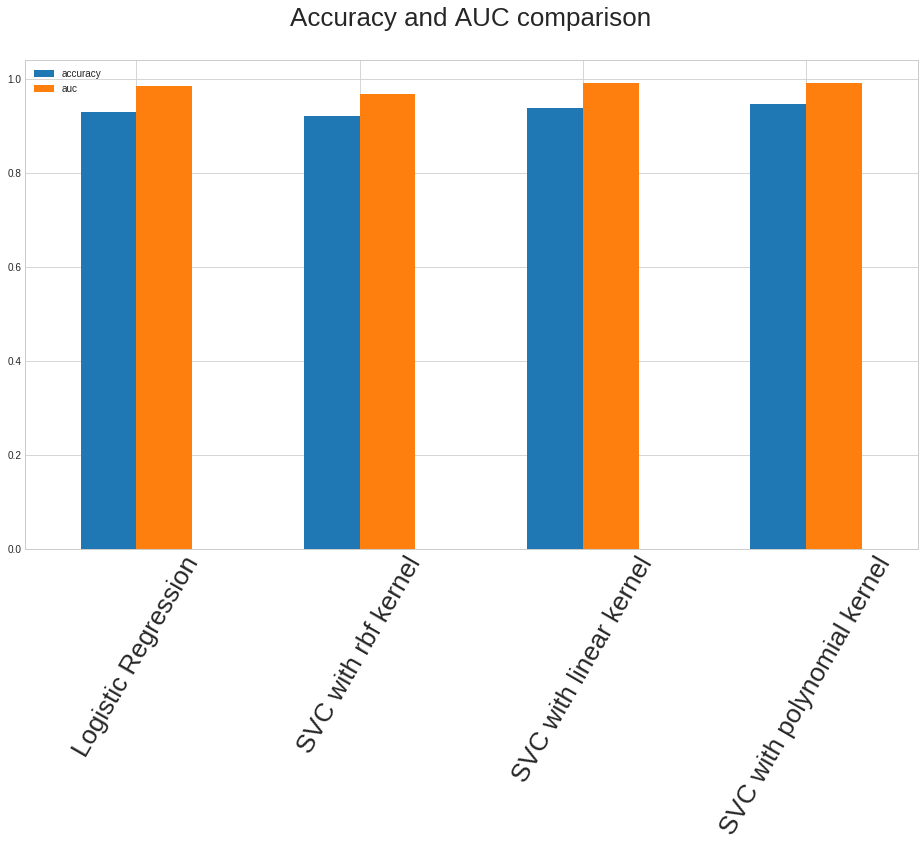

In [36]:
evaluation.loc[:,['accuracy','auc']].plot(kind='bar')
plt.xticks(size = 26, rotation = 60)
plt.title('Accuracy and AUC comparison\n',size=26)
plt.show()

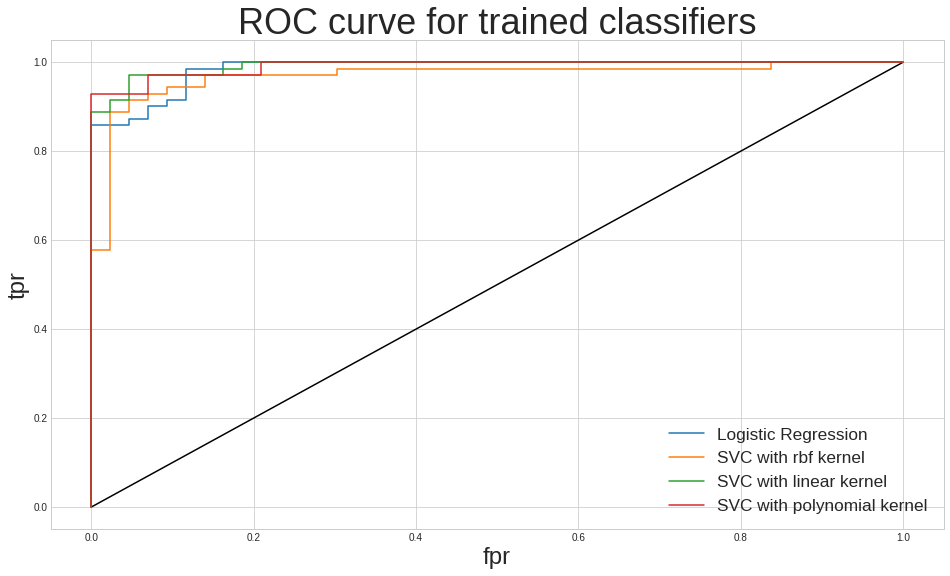

In [37]:
plot_roc_curve(X_test, y_test, classifiers)

# PD plots 

In [43]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

# Partial dependency plots dla klasyfikatorów

Kolejno:
* Regresja logistyczna
* SVM z kernelem rbf
* SVM z kernelem liniowym
* SVM z kernelem wielomianowym

Wnioski: 
* SVM z kernelem liniowym jest podobny do regresji logistycznej - różni się tym, że SVM patrzy na szerekość granicy dzielącej zbiory
* najbardziej nieliniowy jest kernel rbf

[30/30] grid cells ████████████████████ Time elapsed: 0 seconds

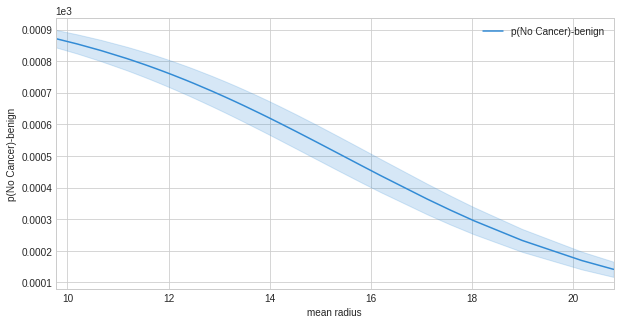

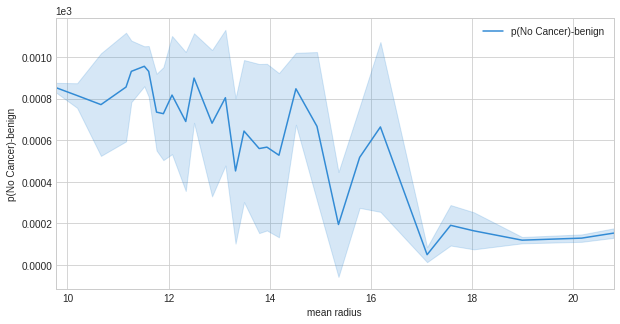

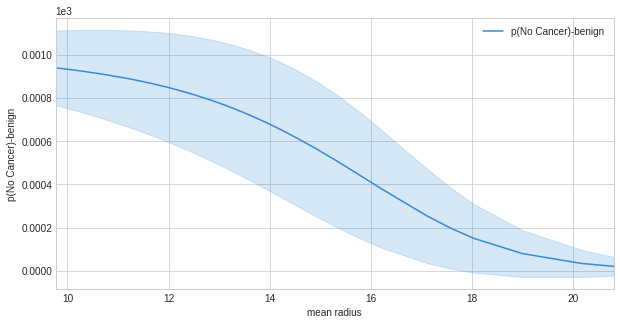

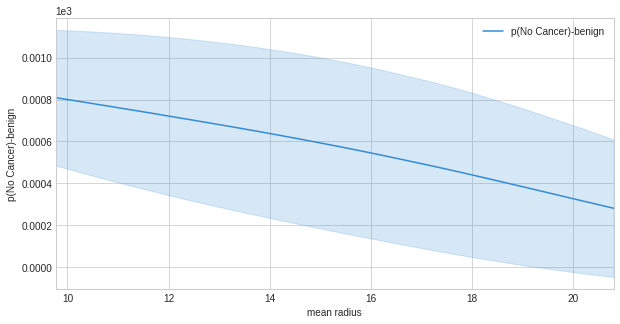

In [49]:
interpretation = Interpretation(X_test, feature_names=X_test.columns)
for model_key, model in classifiers.items():
    pyint_model = InMemoryModel(model.predict_proba, examples=X_train, target_names=['p(Cancer)-malignant', 'p(No Cancer)-benign'])
    interpretation.partial_dependence.plot_partial_dependence(['mean radius'], pyint_model, 
                                                                       grid_resolution=30, 
                                                                       with_variance=True,
                                                                       figsize = (10, 5))